[View in Colaboratory](https://colab.research.google.com/github/rsumit123/Machine_Learning/blob/master/facial_exp_recog.ipynb)

downloading pytorch support libraries


In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip3 install torchvision && pip3 install fastai

creating data directories 

In [0]:
!mkdir data && cd data && mkdir facial_exp_recog




installing google drive api for transferring content to and from drive

In [0]:
!pip3 install -U -q PyDrive

Downloading dataset from google drive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('data/facial_exp_recog/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1ZOHDKvW5DwxeJuhJsseQ7XXuRSnuLrQU' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  print(f.read())

Listing the downloaded files

In [146]:
!cd data && cd fac*/ &&ls -l *




-rw-r--r-- 1 root root    4290400 Aug 23 09:04 test1.zip
-rw-r--r-- 1 root root    3553938 Aug 23 09:04 test.zip
-rw-r--r-- 1 root root 1236510863 Aug 23 13:40 train.zip
-rw-r--r-- 1 root root    6865445 Aug 23 09:04 valid1.zip
-rw-r--r-- 1 root root  179853561 Aug 23 13:40 valid.zip

models:
total 172740
-rw-r--r-- 1 root root 87371257 Aug 23 08:47 224_all.h5
-rw-r--r-- 1 root root 87371257 Aug 23 08:12 224_lastlayer.h5
-rw-r--r-- 1 root root  2139668 Aug 23 07:50 tmp.h5

test:
total 3936
-rw-rw-r-- 1 root root 17826 Nov 23  2009 105b.jpg
-rw-rw-r-- 1 root root 17650 Nov 23  2009 108a.jpg
-rw-rw-r-- 1 root root 18563 Nov 23  2009 110b.jpg
-rw-rw-r-- 1 root root 19181 Nov 23  2009 118a.jpg
-rw-rw-r-- 1 root root 19040 Nov 23  2009 119a.jpg
-rw-rw-r-- 1 root root 18187 Nov 23  2009 11a.jpg
-rw-rw-r-- 1 root root 17829 Nov 23  2009 11b.jpg
-rw-rw-r-- 1 root root 18810 Nov 23  2009 121a.jpg
-rw-rw-r-- 1 root root 20918 Nov 23  2009 132b.jpg
-rw-rw-r-- 1 root root 20002 Nov 23  2009 136b.j

In [0]:
!cd data && cd facial_exp_recog && rm -r train && rm -r valid

unzipping dataset

In [0]:
!cd data && cd fac*/ && unzip valid.zip

In [0]:
from google.colab import files
uploaded = files.download('/usr/local/lib/python3.6/dist-packages/fastai/learner.py')

removing some corrupted files in the dataset

In [0]:
import os
files_dirs=['data/facial_exp_recog/train/surprised/','data/facial_exp_recog/train/happy/']
i=0
for files in os.listdir(files_dirs[0]):
  if files== '70. 840478.jpg' or files=='99. the-best-makeup-for-grey-eyes-blonde-hair-romantic-blue-and-pics-inspiration-green-man-styles_tfast_22666.jpg' or files== '93. 2oruvej.jpg':
    os.remove(files_dirs[0]+files)


In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

installing the python imaging library for processing images

In [0]:
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image
import PIL.image
import PIL.Image

importing the fastai libraries built on top of pytorch

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import PIL

setting the path of the downloaded dataset

In [0]:
PATH = "data/facial_exp_recog/"
sz=224

checking the availability of cuda

In [154]:
torch.cuda.is_available()
torch.backends.cudnn.enabled



True

listing the files in the path

In [155]:
os.listdir(PATH)

['test1.zip',
 'test',
 'valid.zip',
 'tmp',
 'models',
 'valid',
 'valid1.zip',
 'test1',
 'train',
 'test.zip',
 'train.zip']

listing the classes

In [157]:
os.listdir(f'{PATH}train')

['angry', 'sad', 'happy', 'surprised', 'scared', 'neutral', 'disgusted']

viewing some sample images from a particular class

In [158]:



files = os.listdir(f'{PATH}valid/angry')[:5]
files



['63. 46a1461900000578-5117149-image-m-3_1511646764203.jpg',
 '46. aid117179-v4-728px-communicate-with-an-angry-person-step-29-version-2.jpg',
 '92. funny-angry-faces.jpg',
 '21. istock_000001989323xsmall.jpg',
 '26. anger2.jpg']

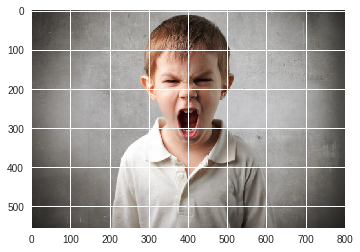

In [162]:
img = plt.imread(f'{PATH}valid/angry/{files[4]}')
plt.imshow(img);

In [163]:
img.shape

(555, 800, 3)

Taking a pretrained imagenet model (resnet34 is a version of the model that won the 2015 ImageNet competition), appending some layers at the bottom of the network and training the last layers according to our data

In [48]:
arch=resnet34 #specifying the pretrained model
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2) #chhose type of image augmentation for the data
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),trn_name='train',val_name='valid',bs=60) #storing the data in the data obj
learn = ConvLearner.pretrained(arch, data, precompute=True)  #getting the pretrained resnet34 model and precomputing the top layers act. the 1st time
#learn.load('224_all')
learn.fit(1e-2, 2) #training the last layers

epoch      trn_loss   val_loss   accuracy   
    0      1.766155   1.83232    0.320144  
    1      1.582859   1.90616    0.306655  


[array([1.90616]), 0.30665467539467184]

plotting the loss curve

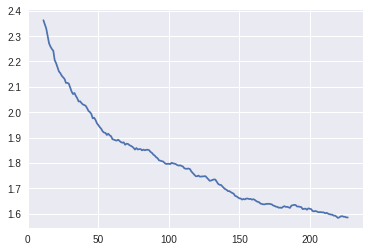

In [49]:
learn.sched.plot_loss()

In [0]:
!cd data/fac* && rm -r tmp

In [0]:
?ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),valid_name=dataset_new,bs=64)

In [0]:
!cd data/fac* && rm -r tmp

In [50]:
data.val_y

array([0, 0, 0, ..., 6, 6, 6])

printing all the data classes

In [51]:
# from here we know that angry = 0, disgusted=1, happy =2, neutral =3, sad = 4, scared =5 , surprised =6.
data.classes

['angry', 'disgusted', 'happy', 'neutral', 'sad', 'scared', 'surprised']

generating predictions

In [52]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1112, 7)

In [53]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities select the max
probs = np.exp(log_preds[:,1])
preds

array([2, 2, 4, ..., 6, 6, 3])

**Analysing results**

some utility functions to show incorrectly classified and correctly classified images

In [0]:
def rand_by_mask(mask): 
  
  return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
  #print('randbymask',rand_by_mask((preds == data.val_y)==is_correct))
  return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = ['prediction= '+data.classes[preds[x]] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


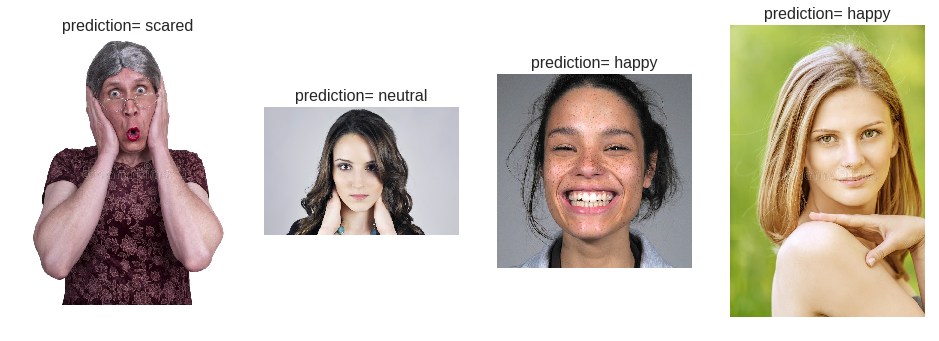

In [38]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


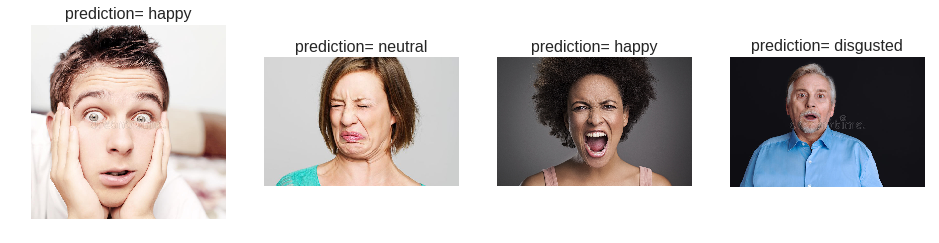

In [39]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

**Optimising Results**

Finding the optimal learning rate using techniques mentioned in the 2015 paper https://arxiv.org/abs/1506.01186 , where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. Plotting the learning rate across batches to see what this looks like.

In [0]:
#creating a new learner object 
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [55]:
#lr_find() helps us find the optimal learning rate 
lrf=learn.lr_find()



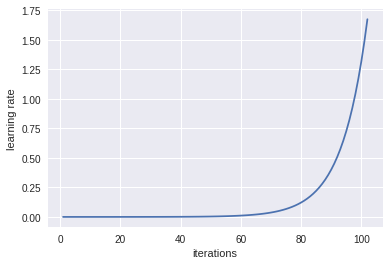

In [56]:
learn.sched.plot_lr()

From the above plot it is visible that lr_find() increases the learning rate from a very small value until the loss stops decreasing, now plotting the loss curve vs the learning rate

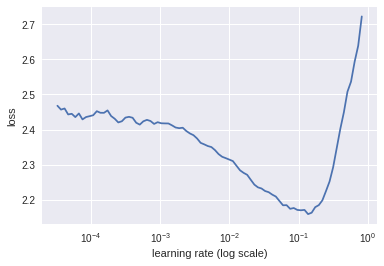

In [57]:
learn.sched.plot()

We can see that the loss is decreasing the most at learning rate 1e-2 . therefore selecting that as my optimal learning rate

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.2) #specifying the image augmentation


Feeding the data to the data object by passing the directory names of the stored data  , the augmentation obj and the batch size

In [59]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms,trn_name='train',val_name='valid',bs=75) #
learn = ConvLearner.pretrained(arch, data, precompute=True) #getting a new learner
learn.fit(4*1e-2, 1) #training the data 

epoch      trn_loss   val_loss   accuracy   
    0      1.932465   1.908332   0.297662  


[array([1.90833]), 0.297661870952508]

setting precompute= False to see the benefits of image augmentation

In [0]:
learn.precompute=False


Training the model with our data by not using precompute and using learning rate annealing (The cycle_len=2 parameter applies a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses and then it resets it to get into a better minima) . The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what is actually being passed as the 2nd parameter to fit().

In [61]:
learn.fit(1e-2, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.603359   1.834461   0.296763  
    1      1.540921   1.812684   0.304856  
    2      1.543147   1.842197   0.304856  
    3      1.5079     1.818185   0.311151  
    4      1.516594   1.817722   0.317446  
    5      1.465223   1.829737   0.309353  


[array([1.82974]), 0.30935252144959546]

Showing the variation of learning rate

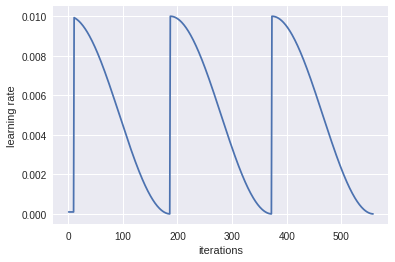

In [62]:
learn.sched.plot_lr()

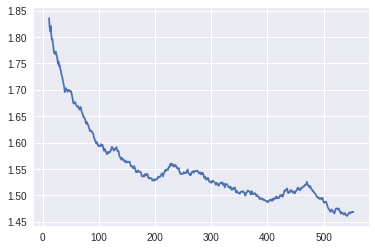

In [64]:
learn.sched.plot_loss() #plotting the loss

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

Unfreezing all the layers By default when a learner object is created, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when fit is called.

In [0]:
learn.unfreeze()

Since we have unfrozen all the layers training them all wiith the same lrs will not be beneficial . So creating a lr array where the top and middle layers will be trained at a much slower rate than the bottom layer.

In [0]:
lr=np.array([1e-2/10.,1e-2/10.,1e-2/5])

In [137]:
learn.fit(lr, 2, cycle_len=1,cycle_mult=2) #calling fit method with the new lr array

epoch      trn_loss   val_loss   accuracy   
    0      0.48145    1.889331   0.504496  
    1      0.504949   1.953509   0.48741   
    2      0.386198   1.892977   0.510791  


[array([1.89298]), 0.510791373928245]

The cycle_mult parameter increases the iterations after the lr is reset as the no_of_cycles increases

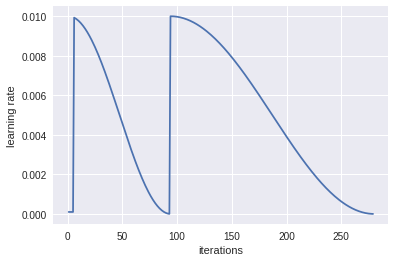

In [138]:
learn.sched.plot_lr() #seeing the variation in learning rate


In [0]:
learn.sched.plot_loss()

In [0]:
learn.save('224_all')


In [0]:
learn.load('224_all')

Using test-time augmentation to predict the results

In [140]:
log_preds,y = learn.TTA() #test time augmentation
probs = np.mean(np.exp(log_preds),0) #taking the mean of the predictions


Finding the accuracy

In [141]:
accuracy_np(probs, y)

0.512589928057554

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

plotting confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 58  10  11  14  20  11   3]
 [ 21  62  26  14  33  10   7]
 [  0   0 160  27  16   1  11]
 [  3   2  18  79  11   3   2]
 [  6   5  12  73  87   5   6]
 [  3   0   8  17  28  32  30]
 [  1   3  14  22  11   9 107]]


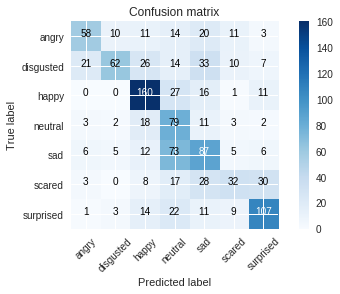

In [78]:
plot_confusion_matrix(cm, data.classes)


In [0]:
learn.load('224_all')

Checking the predictions for my own images

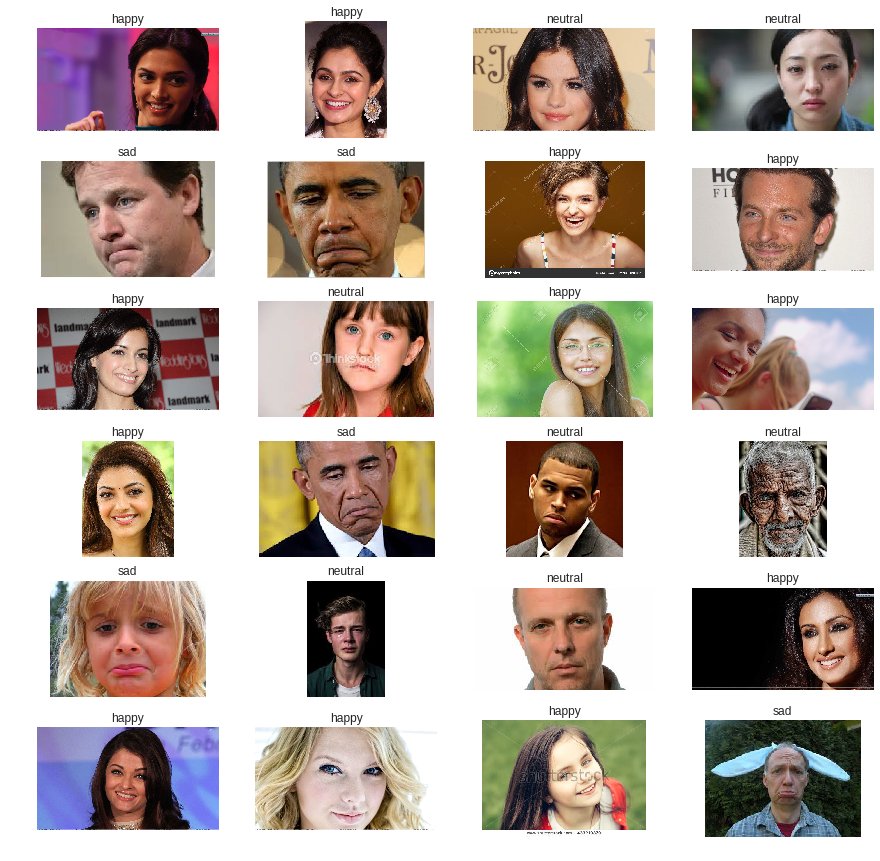

In [107]:
columns = 4
rows = 6
fn = data.val_ds.fnames[0]
fig=plt.figure(figsize=(15, 15))

 #Method 1.
import os
direc='test1/'
imgs_list=[]
i=0
for files in list(os.listdir(PATH+direc)):
    i+=1
    fn=PATH+direc+files
    
    img = plt.imread(PATH+direc+files)
    a=fig.add_subplot(rows,columns,i)
    a.axis('off')
    plt.imshow(img)
    imgs_list.append(img)
    




    
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    
    im = val_tfms(open_image(PATH + direc+files)) # open_image() returns numpy.ndarray
    preds = learn.predict_array(im[None])
    plt.title(data.classes[np.argmax(preds)]);
    
